# Import

In [1]:
# torch package
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# dataset packagea
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# metrcis
from sklearn.metrics import accuracy_score, classification_report

# ETC
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# SimpleCNN-Model

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        [(H_in + 2P - K)/S] + 1
        '''

        self.conv_layer1 = nn.Sequential(\
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(0.2))
        

        self.conv_layer2 = nn.Sequential(\
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(0.1))


        self.dense_layer = nn.Sequential(\
            nn.Linear(64 * 7 * 7, 10))
        
        

    def forward(self, x):
        # (batch_size, 1, 28, 28)
        out = self.conv_layer1(x) 
        
        # (batch_size, 32, 14, 14)
        out = self.conv_layer2(out) 

        # (batch_size, 64, 7, 7)
        out = out.view(out.size(0), -1)

        # (batch_size, 64*7*7)
        cnn_output = self.dense_layer(out) 

        # (batch_size, 10)
        return cnn_output

# Train

In [3]:
def train(model, config, train, valid, optimizer=False, loss=False):
    train_loss_history = []
    valid_loss_history = []
    
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_function = nn.CrossEntropyLoss()


    for i in range(config.epochs):

        train_loss_ = 0
        model.train()
        with torch.enable_grad():
            for feature, label in train:
                feature, label = feature.to(config.device), label.to(config.device)
                optimizer.zero_grad()               
                outputs = model(feature)
                
                loss = loss_function(outputs, label)
                
                loss.backward()
                optimizer.step()

                train_loss_ += loss.item()

        train_loss_ /= config.batch_size
        train_loss_history.append(train_loss_)
        


        valid_loss_ = 0
        model.eval()
        with torch.no_grad():
            for feature, label in valid:
                feature, label = feature.to(config.device), label.to(config.device)
                # outputs = model(feature.view(config.batch_size, 1, 28, 28))
                outputs = model(feature)

                loss = loss_function(outputs, label)
                
                valid_loss_ += loss.item()

        valid_loss_ /= config.batch_size
        valid_loss_history.append(valid_loss_)

        clear_output(wait=True) # 주피터 셀 초기화

        if (i+1)%int((config.epochs)*0.1)==0:
            print(f"epoch : {i+1} Loss(train) : {train_loss_history[-1]:.3f}  Loss(valid) : {valid_loss_history[-1]:.3f}")

            plt.plot(train_loss_history, label='Training loss')
            plt.plot(valid_loss_history, label='Validation loss')
            plt.ylim(0, 5)
            plt.legend()
            plt.show()
        




    
    # plt.plot(train_loss_history, label='Training loss')
    # plt.plot(valid_loss_history, label='Validation loss')
    # plt.legend()
    # plt.show()
    print("="*40)
    print("Training loss: ", train_loss_history[-1])
    print("Validation loss: ", valid_loss_history[-1])
    print("="*40)

# Predict

In [4]:
def predict_evaluate(model, config, test):
    model.eval()
    output_list = []
    acc = []

    y_pred = torch.Tensor()
    y_test = torch.Tensor()
    with torch.no_grad():
        for feature, label in test:
            feature, label = feature.to(config.device), label.to(config.device)
            outputs = model(feature)
            output_list.append(outputs)
            outputs = outputs.cpu()
            _, outputs = torch.max(outputs, 1)
            
            label = label.cpu()

            acc.append(accuracy_score(label, outputs))
            y_pred = torch.cat((y_pred, outputs), dim=0)
            y_test = torch.cat((y_test, label), dim=0)

    
    print(f"Accuracy: {(sum(acc)/len(acc)):.3f}")

    return y_test, y_pred

# Hyperparameter config

In [5]:
class config():
    def __init__(self, device, learning_rate=0.001, epochs=100, batch_size = 128):
        self.learning_rate = learning_rate

        self.batch_size = batch_size
        self.epochs = epochs

        self.device = device

# Dataset

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True) # 48000
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True) # 12000 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)  # 10000


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Model

In [7]:
train_config = config(device = device,
                      learning_rate=0.001,
                      epochs = 100,
                      batch_size = 128)

In [8]:
cnn = SimpleCNN().to(device)

epoch : 100 Loss(train) : 0.205  Loss(valid) : 0.216


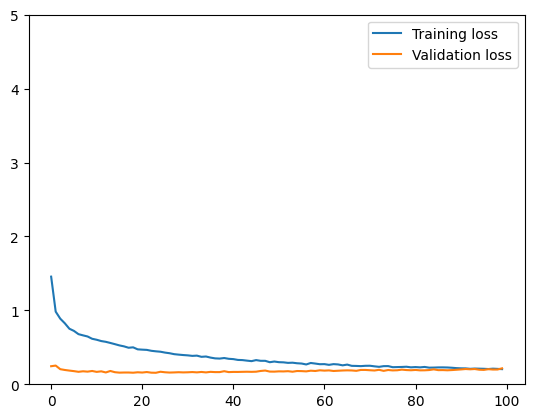

Training loss:  0.20484735281206667
Validation loss:  0.21576696445117705


In [9]:
train(cnn, train_config, train_loader, valid_loader)

# Evaluation

In [10]:
y_test, y_pred = predict_evaluate(cnn, train_config, test_loader)

Accuracy: 0.918


In [11]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      1000
         1.0       0.99      0.99      0.99      1000
         2.0       0.85      0.91      0.88      1000
         3.0       0.93      0.89      0.91      1000
         4.0       0.88      0.86      0.87      1000
         5.0       0.98      0.99      0.98      1000
         6.0       0.80      0.74      0.77      1000
         7.0       0.95      0.98      0.96      1000
         8.0       0.98      0.99      0.99      1000
         9.0       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

